In [1]:
ENV["GUROBI_HOME"] = "C:\\gurobi951\\win64"
ENV["GRB_LICENSE_FILE"] = "C:\\gurobi951\\win64\\gurobi.lic"

using Pkg
Pkg.add("JuMP")
Pkg.add("Gurobi")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("Distances")

    Updating registry at `C:\Users\ColeNelson\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\ColeNelson\.julia\environments\v1.7\Manifes

In [2]:
using JuMP
using Gurobi
using DataFrames
using Plots
using LinearAlgebra
using Distances

In [3]:
# BCycle Stations must be listed first.
# Points of Interest must be listed second.
# x_coord y_coord is_poi name
points = [
    -5 +4 false "BCycle Station #1"
    +0 +0 false "BCycle Station #2"
    +1 -1 false "BCycle Station #3"
    -6 -3 false "BCycle Station #4"
    +4 +6 false "BCycle Station #5"
    -4 +0 false "BCycle Station #6"
    -2 -7 false "BCycle Station #7"
    +6 +3 false "BCycle Station #8"
    +7 +6 true "Union South"
    +1 -5 true "Memorial Library"
    -5 +2 true "Wandos"
    -6 +0 true "Eagle Heights"
    -9 +3 true "Engineering Hall"
    +3 +8 true "The Madison Club"
    -6 -7 true "The Comedy Club"
    +1 +2 true "The Capitol"
]

just_coords = hcat(points[:,1], points[:,2])

16×2 Matrix{Int64}:
 -5   4
  0   0
  1  -1
 -6  -3
  4   6
 -4   0
 -2  -7
  6   3
  7   6
  1  -5
 -5   2
 -6   0
 -9   3
  3   8
 -6  -7
  1   2

In [4]:
# Extracts important information from the points matrix
function extract_names_and_points(points=points)
    bcycle_points = Array{Float64}(undef, 0, 2)
    interest_points = Array{Float64}(undef, 0, 2)
    bcycle_names = []
    interest_names = []
    for point in eachrow(points)
        if point[3] # is a point of interest
            interest_points = vcat(interest_points, [point[1] point[2]])
            interest_names = vcat(interest_names, point[4])
        else
            bcycle_points = vcat(bcycle_points, [point[1] point[2]])
            bcycle_names = vcat(bcycle_names, point[4])
        end
    end
    return [bcycle_names, bcycle_points, interest_names, interest_points]
end

extract_names_and_points (generic function with 2 methods)

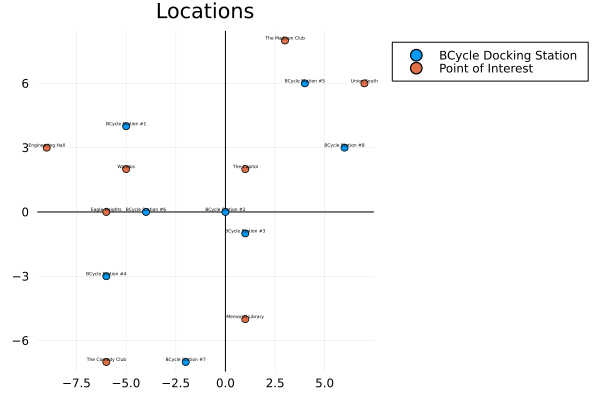

In [5]:
# Creates a nice plot of the city map
function plot_city_map(points=points, with_labels=true)
    (bcycle_names, bcycle_points, interest_names, interest_points) = extract_names_and_points(points)
    if with_labels
        plot(bcycle_points[:,1], bcycle_points[:,2], seriestype = :scatter, title = "Locations", framestyle =:zerolines, labels="BCycle Docking Station", legend=:outertopright, series_annotations=text.(bcycle_names, :bottom, 3))
        plot!(interest_points[:,1], interest_points[:,2], seriestype = :scatter, labels="Point of Interest", series_annotations=text.(interest_names, :bottom, 3)) 
    else
        plot(bcycle_points[:,1], bcycle_points[:,2], seriestype = :scatter, title = "Locations", framestyle =:zerolines, labels="BCycle Docking Station", legend=:outertopright)
        plot!(interest_points[:,1], interest_points[:,2], seriestype = :scatter, labels="Point of Interest") 
    end
end
plot_city_map()

In [6]:
# Calculates the time between two points as the eucl.
# distance times some constant factor
function calculate_time(point1, point2)
    TIME_FACTOR = (pi)^(pi/2) # produces moderately-long rides
    return euclidean(point1, point2) * TIME_FACTOR
end

# Generates a fully connected graph connection each point
# with their travel time.
function generate_graph(all_points)
    num_points = size(all_points)[1]
    graf = Array{Float64}(undef, num_points, num_points)
    for i in 1:num_points
        for j in 1:num_points
            graf[i,j] = calculate_time(all_points[i,:], all_points[j,:])
        end
    end
    return graf
end

graf = generate_graph(just_coords)
graf

16×16 Matrix{Float64}:
  0.0     38.6646   47.1613   42.6979  …   54.009    66.6962  38.1901
 38.6646   0.0       8.53957  40.5068      51.592    55.6712  13.5023
 47.1613   8.53957   0.0      43.9601      55.6712   55.6712  18.1152
 42.6979  40.5068   43.9601    0.0         85.8217   24.1536  51.9442
 55.6712  43.5435   45.987    81.2382      13.5023   99.037   30.192
 24.8969  24.1536   30.7899   21.7717  …   64.189    43.9601  32.5177
 68.8482  43.9601   40.5068   34.1583      95.4753   24.1536  57.2852
 66.6962  40.5068   38.6646   81.0135      35.2096   94.3227  30.7899
 73.4602  55.6712   55.6712   95.4753      27.0045  111.014   43.5435
 65.3152  30.7899   24.1536   43.9601      79.4226   43.9601  42.2687
 12.0768  32.5177   40.5068   30.7899  …   60.3839   54.68    36.2303
 24.8969  36.2303   42.6979   18.1152      72.7119   42.2687  43.9601
 24.8969  57.2852   65.0355   40.5068      78.4991   63.0426  60.6851
 54.009   51.592    55.6712   85.8217       0.0     105.629   38.190

In [7]:
# Extracts and nicely packages the values from the JuMP variables.
function package_soln(first_point, last_point, x, t, btime, n)
    sol_x = zeros(n, n)
    for i=1:n
        for j=1:n
            sol_x[i,j] = JuMP.value(x[i,j])
        end
    end

    sol_t = zeros(n)
    for i=1:n
       sol_t[i] = JuMP.value(t[i])
    end

    sol_btime = zeros(n)
    for i=1:n
       sol_btime[i] = JuMP.value(btime[i])
    end
    return (first_point, last_point, sol_x, sol_t, sol_btime, n)
end

package_soln (generic function with 1 method)

In [8]:
# Solves the optimization problem.
function solve_my_ride(start_bcycle, end_bcycle, poi, graf=graf, max_time=90)
    (bcycle_names, bcycle_points, interest_names, interest_points) = extract_names_and_points(points)
    
    # Relative to interest points (staring from 0)
    # Use this for interest name lookups.
    client_interests_relative = []
    
    # Absolute to graf.
    # Use this for distance lookups.
    client_interests_absolute = []
    
    # THIS ASSUMES points HAS bcycle_points FOLLOWED BY interest_points
    for dest in poi
        append!(client_interests_relative, findfirst(x->x==dest, interest_names))
        append!(client_interests_absolute, size(bcycle_points)[1] + findfirst(x->x==dest, interest_names))
    end
    
    # Lookups and ranges for the optimization problem
    maxd = findmax(graf)[1]
    n = length(graf[:,1])
    first_point = findfirst(x->x==start_bcycle, bcycle_names)
    last_point = findfirst(x->x==end_bcycle, bcycle_names)
    non_first_points = [collect(1:(first_point - 1)); collect((first_point + 1):n)]
    non_last_points = [collect(1:(last_point - 1)); collect((last_point + 1):n)]
    non_end_points = setdiff(collect(1:n), [first_point, last_point])

    # Defines whether or not a point is a docking station
    isdocking = []
    for i=1:length(bcycle_points[:,1])
       append!(isdocking, 1) 
    end
    for i=1:length(interest_points[:,1])
       append!(isdocking, 0) 
    end

    # Defines how badly a client wants to visit a point.
    # Currently boolean: 1 for points of interest, 0 otherwise.
    scores = []
    for i=1:n
        if findfirst(x->x==i, client_interests_absolute) != nothing
            append!(scores, 1)
        else
            append!(scores, 0)
        end
    end
    
    m = Model(with_optimizer(Gurobi.Optimizer, OutputFlag=0))

    # Assignment Matrix
    @variable(m, x[1:n,1:n], Bin)

    # Time (Itinerary) Variable
    @variable(m, t[1:n] >= 0)

    # Remaining time on Bcycle
    @variable(m, btime[1:n] >= 0)

    # Start from node first_point
    @constraint(m, sum( x[j,first_point] for j=non_first_points) == 0)
    @constraint(m, sum( x[first_point,j] for j=non_first_points) == 1)
    @constraint(m, t[first_point] == 0)     # t=0 when we start
    @constraint(m, btime[first_point] == 0) # We start with a zero remaining time on the Bcycle (but starting point is docking station)

    # End at node last_point
    @constraint(m, sum( x[j,last_point] for j=non_last_points) == 1)
    @constraint(m, sum( x[last_point,j] for j=non_last_points) == 0)

    # Do not stay in a node
    for i=1:n
        @constraint(m, x[i,i]==0)
    end

    # Our solution forms a simple path
    for k in non_end_points
        @constraint(m, sum( x[i,k] for i=1:n) == sum( x[k,i] for i=1:n) )
        @constraint(m, sum( x[k,i] for i=1:n) <= 1)
    end

    # Here we can add constraints that say that you should arrive at each node at a specific time window

    # Remaining time on Bcycle gets updated
    for i in non_first_points  # i is the node you are going to
        for j in non_last_points   # j is the node you are coming from
            
            # Update time variable
            @constraint(m, t[i] >= t[j] + graf[j,i]*x[j,i] - (n+1)*maxd*(1-x[j,i]))
            
            # A BCycle can only be used for 0-90 minutes
            @constraint(m, 0 <= btime[i] <= max_time)
            if graf[j,i] > max_time  # not possible to assign
                @constraint(m, x[j,i] == 0)
            elseif isdocking[j] == 1 # btime is based on a fresh bcycle
                @constraint(m, btime[i] <= (max_time-graf[j,i])*x[j,i] + (max_time+1)*(1-x[j,i]))
                @constraint(m, btime[i] >= (max_time-graf[j,i])*x[j,i])
            else                     # btime is based on a used bcycle
                @constraint(m, btime[i] <= (btime[j]-graf[j,i])*x[j,i] + (max_time+1)*(1-x[j,i]))
                @constraint(m, btime[i] >= (btime[j]-graf[j,i])*x[j,i])
            end
        end
    end

    # Cannot spend more than 90 minutes on one location
    @constraint(m, t[n] <= max_time)
    
    # We MUST visit every point of interest
    for i in 1:n
        @constraint(m, sum(x[:, i]) >= scores[i])
    end

    # In the future, we may instead seek for the
    # maximization of fulfillment for the clients' desires.
    #@objective(m, Max, sum( sum( scores[i]* x[i,j] for j=1:n) for i=1:n))
    
    # For now, we wish to find shortest route
    # This is equivilant to minimizing the inf-norm.
    @objective(m, Min, sum(t.^1/10000000))
    @time optimize!(m)
    
    println("Route Finder Status: ", termination_status(m))
    println()
    
    # Nicely package solution.
    return package_soln(first_point, last_point, x, t, btime, n)
end

solve_my_ride (generic function with 3 methods)

In [9]:
# Displays a single node in the format
# node_name(time,time_left_on_bcycle)
function display_node(name, t, btime)
    print(name, "(",round(t,digits=2),",",round(btime,digits=2),")")
end

display_node (generic function with 1 method)

In [10]:
# Displays the solution path.
function display_soln(first_point, last_point, x, t, btime, n, points)
    # This prints the solution (prints the nodes of the path in order)
    println("node_name(time,time_left_on_bcycle)")
    current_node=first_point
    while current_node != last_point
        display_node(points[current_node,4], t[current_node], btime[current_node])
        println()
        print(" -> ")
        for j=1:n
            if j!=current_node && x[current_node,j]>0
                current_node = j
                break
            end

        end
    end
    display_node(points[current_node,4], t[current_node], btime[current_node])
end

display_soln (generic function with 1 method)

In [11]:
# Client Specification
# May take up to 30 seconds to solve.
soln = solve_my_ride("BCycle Station #4", "BCycle Station #1", ["The Madison Club", "Engineering Hall", "The Comedy Club"])
display_soln(soln..., points)
# We return a route for them.

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-13
 16.669563 seconds (7.30 M allocations: 436.309 MiB, 0.74% gc time, 22.31% compilation time)
Route Finder Status: OPTIMAL

node_name(time,time_left_on_bcycle)
BCycle Station #4(0.0,0.0)
 -> The Comedy Club(24.15,65.85)
 -> BCycle Station #6(68.11,21.89)
 -> The Madison Club(132.3,25.81)
 -> BCycle Station #5(145.8,12.31)
 -> BCycle Station #2(189.35,46.46)
 -> Engineering Hall(246.63,32.71)
 -> BCycle Station #1(271.53,7.82)

In [12]:
soln = solve_my_ride("BCycle Station #2", "BCycle Station #8", ["Wandos", "Engineering Hall", "The Comedy Club"])
display_soln(soln..., points)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-13
  0.735708 seconds (27.14 k allocations: 1.914 MiB)
Route Finder Status: OPTIMAL

node_name(time,time_left_on_bcycle)
BCycle Station #2(0.0,0.0)
 -> Wandos(32.52,57.48)
 -> BCycle Station #1(44.59,45.41)
 -> Engineering Hall(69.49,65.1)
 -> BCycle Station #4(110.0,24.6)
 -> The Comedy Club(134.15,65.85)
 -> BCycle Station #7(158.31,41.69)
 -> BCycle Station #8(235.63,12.67)

In [13]:
`

LoadError: syntax: incomplete: invalid "`" syntax